In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

## Your First Model

### Running Your First Notebook

In [3]:
# CLICK ME
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.164282,0.017199,0.006766,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.061079,0.013779,0.004060,01:06


In [6]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [7]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader = SimpleNamespace(data = ['/content/IMG_0014.JPG'])

In [8]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.005676


## A Bit of Deep Learning Jargon

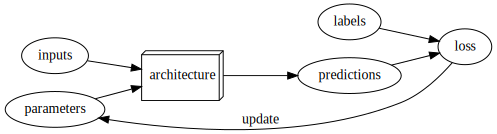

In [13]:
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

### Limitations Inherent To Machine Learning

From this picture we can now see some fundamental things about training a deep learning model:

- A model cannot be created without data.
- A model can only learn to operate on the patterns seen in the input data used to train it.
- This learning approach only creates *predictions*, not recommended *actions*.
- It's not enough to just have examples of input data; we need *labels* for that data too (e.g., pictures of dogs and cats aren't enough to train a model; we need a label for each one, saying which ones are dogs, and which are cats).

Generally speaking, we've seen that most organizations that say they don't have enough data, actually mean they don't have enough *labeled* data. If any organization is interested in doing something in practice with a model, then presumably they have some inputs they plan to run their model against. And presumably they've been doing that some other way for a while (e.g., manually, or with some heuristic program), so they have data from those processes! For instance, a radiology practice will almost certainly have an archive of medical scans (since they need to be able to check how their patients are progressing over time), but those scans may not have structured labels containing a list of diagnoses or interventions (since radiologists generally create free-text natural language reports, not structured data). We'll be discussing labeling approaches a lot in this book, because it's such an important issue in practice.

Since these kinds of machine learning models can only make *predictions* (i.e., attempt to replicate labels), this can result in a significant gap between organizational goals and model capabilities. For instance, in this book you'll learn how to create a *recommendation system* that can predict what products a user might purchase. This is often used in e-commerce, such as to customize products shown on a home page by showing the highest-ranked items. But such a model is generally created by looking at a user and their buying history (*inputs*) and what they went on to buy or look at (*labels*), which means that the model is likely to tell you about products the user already has or already knows about, rather than new products that they are most likely to be interested in hearing about. That's very different to what, say, an expert at your local bookseller might do, where they ask questions to figure out your taste, and then tell you about authors or series that you've never heard of before.

### How Our Image Recognizer Works

- `from fastai.vision.all import *`: import all required components
- `path = untar_data(URLs.PETS)/'images'`: extract standard dataset
- `def is_cat(x): return x[0].isupper()`: Define the function that which of the images have cats and which ones have dogs. This is based on the structure set by the dataset authors.
- `dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))`: data loader to load into the CNN
- `learn = vision_learner(dls, resnet34, metrics=error_rate)`: define the CNN model
- `learn.fine_tune(1)`: fine tune a petrained model with the new data

In [23]:
doc(vision_learner)

,Type,Default,Details
dls,,,No Content
normalize,bool,True,No Content
loss_func,,None,No Content
opt_func,function,Adam,No Content
lr,float,0.001,No Content
splitter,,None,No Content
cbs,,None,No Content
metrics,,None,No Content
path,,None,learner args
model_dir,str,models,No Content


In [14]:
doc(ImageDataLoaders.from_name_func)

In [17]:
doc(untar_data)

,Type,Default,Details
url,,,No Content
archive,,None,No Content
data,,None,No Content
c_key,str,data,No Content
force_download,bool,False,", extract_func=file_extract, timeout=4):"


### What Our Image Recognizer Learned

### Image Recognizers Can Tackle Non-Image Tasks

### Jargon Recap

## Deep Learning Is Not Just for Image Classification

In [20]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,2.852129,2.454686,00:02


epoch,train_loss,valid_loss,time
0,1.758755,1.648877,00:02
1,1.499862,1.323123,00:02
2,1.364269,1.267552,00:02
3,1.212407,0.935333,00:02
4,1.095662,0.853600,00:02
5,0.995486,0.824190,00:02
6,0.911000,0.776707,00:02
7,0.845478,0.784209,00:02


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


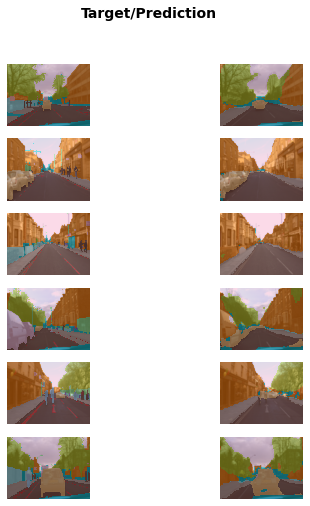

In [22]:
learn.show_results(max_n=6, figsize=(7,8))

In [33]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.466335,0.392898,0.824600,03:25


epoch,train_loss,valid_loss,accuracy,time
0,0.300871,0.243876,0.902880,07:26
1,0.242159,0.216182,0.914400,07:27
2,0.181781,0.193835,0.927000,07:26
3,0.143483,0.196538,0.928200,07:26


If you hit a "CUDA out of memory error" after running this cell, click on the menu Kernel, then restart. Instead of executing the cell above, copy and paste the following code in it:

```
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)
```

This reduces the batch size to 32 (we will explain this later). If you keep hitting the same error, change 32 to 16.

In [34]:
learn.predict("I really liked that movie!")

('pos', TensorText(1), TensorText([1.1524e-04, 9.9988e-01]))

### Sidebar: The Order Matters

### End sidebar

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(3)

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

In [ ]:
learn.show_results()

### Sidebar: Datasets: Food for Models

### End sidebar

## Validation Sets and Test Sets

### Use Judgment in Defining Test Sets

## A _Choose Your Own Adventure_ moment

## Questionnaire

It can be hard to know in pages and pages of prose what the key things are that you really need to focus on and remember. So, we've prepared a list of questions and suggested steps to complete at the end of each chapter. All the answers are in the text of the chapter, so if you're not sure about anything here, reread that part of the text and make sure you understand it. Answers to all these questions are also available on the [book's website](https://book.fast.ai). You can also visit [the forums](https://forums.fast.ai) if you get stuck to get help from other folks studying this material.

For more questions, including detailed answers and links to the video timeline, have a look at Radek Osmulski's [aiquizzes](http://aiquizzes.com/howto).

1. Do you need these for deep learning?

   - Lots of math T / F
   - Lots of data T / F
   - Lots of expensive computers T / F
   - A PhD T / F
   
1. Name five areas where deep learning is now the best in the world.
1. What was the name of the first device that was based on the principle of the artificial neuron?
1. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?
1. What were the two theoretical misunderstandings that held back the field of neural networks?
1. What is a GPU?
1. Open a notebook and execute a cell containing: `1+1`. What happens?
1. Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.
1. Complete the Jupyter Notebook online appendix.
1. Why is it hard to use a traditional computer program to recognize images in a photo?
1. What did Samuel mean by "weight assignment"?
1. What term do we normally use in deep learning for what Samuel called "weights"?
1. Draw a picture that summarizes Samuel's view of a machine learning model.
1. Why is it hard to understand why a deep learning model makes a particular prediction?
1. What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?
1. What do you need in order to train a model?
1. How could a feedback loop impact the rollout of a predictive policing model?
1. Do we always have to use 224×224-pixel images with the cat recognition model?
1. What is the difference between classification and regression?
1. What is a validation set? What is a test set? Why do we need them?
1. What will fastai do if you don't provide a validation set?
1. Can we always use a random sample for a validation set? Why or why not?
1. What is overfitting? Provide an example.
1. What is a metric? How does it differ from "loss"?
1. How can pretrained models help?
1. What is the "head" of a model?
1. What kinds of features do the early layers of a CNN find? How about the later layers?
1. Are image models only useful for photos?
1. What is an "architecture"?
1. What is segmentation?
1. What is `y_range` used for? When do we need it?
1. What are "hyperparameters"?
1. What's the best way to avoid failures when using AI in an organization?

### Further Research

Each chapter also has a "Further Research" section that poses questions that aren't fully answered in the text, or gives more advanced assignments. Answers to these questions aren't on the book's website; you'll need to do your own research!

1. Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?
1. Try to think of three areas where feedback loops might impact the use of machine learning. See if you can find documented examples of that happening in practice.